In [1]:
# =============================================
# 1. CONFIGURACIÓN INICIAL
# =============================================

# 1️⃣ Importaciones
import pandas as pd
import numpy as np
import joblib
import os
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, r2_score
from scipy.stats import spearmanr
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt


# Ruta al DW
db_path = "C:/Users/Nico/Desktop/DATA SCIENCE/PP- VOLUNTAREADO/chivas-ml/data/external/chivas_dw.sqlite"

# Conexión
conn = sqlite3.connect(db_path)

# Cargar la vista combinada
df = pd.read_sql_query("SELECT * FROM vw_predicciones_diarias_extendida_v6_ref_actual", conn)
# Cerrar conexión
conn.close()

print(f"Registros cargados: {len(df)}")
df.head()


Registros cargados: 3330


,id_jugador,Fecha,microciclo_ref,tipo_dia_next,Tipo_Dia,Edad,Peso_kg,Estatura_cm,Posicion,Linea,...,pct_pred_mas1_DT:1,DT_pred_mas1_valor:1,pct_pred_mas2_DT:1,DT_pred_mas2_valor:1,pct_pred_mas3_DT,DT_pred_mas3_valor,CT_total_actual,CE_total_actual,CS_total_actual,CR_total_actual
0,25,2025-05-23,0,NaN,ENTRENO,26,70.0,176.0,Delantero,Extremo,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,25,2025-05-24,0,NaN,ENTRENO,26,70.0,176.0,Delantero,Extremo,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,25,2025-05-26,1,NaN,ENTRENO,26,70.0,176.0,Delantero,Extremo,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,25,2025-05-27,1,NaN,ENTRENO,26,70.0,176.0,Delantero,Extremo,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,25,2025-05-28,1,NaN,ENTRENO,26,70.0,176.0,Delantero,Extremo,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2]:
# Primero, como hicimos en todos los dataset a entrenar, excluimos todos los jugadores 
# que no proporcionan valor, al igual que los microciclos donde no se compitió:

# =============================================
# 2.1 FILTRO DE JUGADORES Y MICRO-CICLOS
# =============================================

print(f"Registros cargados pre filtrado: {len(df)}\n")

# Jugadores que deben excluirse
jugadores_excluir = [1, 2, 3, 12, 30]

# Filtrar jugadores no válidos
df = df[~df["id_jugador"].isin(jugadores_excluir)]

# fFiltramos los días nulos o no validos (elimina microciclos fuera de competencia):
df = df[df['tipo_dia_next'].notnull()]


print(f"Registros cargados post filtrado: {len(df)}\n")
# Distribución de la etiqueta
print("\nDistribución de tipo_semana_next:")
print(df['tipo_semana_next'].value_counts(normalize=True) * 100)


Registros cargados pre filtrado: 3330

Registros cargados post filtrado: 2498


Distribución de tipo_semana_next:
tipo_semana_next
RECUPERO    50.420168
CARGA       29.957983
MANTENER    19.621849
Name: proportion, dtype: float64


In [3]:
# =====================================================
# 2️⃣ FEATURE ENGINEERING
# =====================================================
# 🔹 Ratios respecto al microciclo de referencia (solo con columnas existentes)
df['CE_ratio_ref'] = df['CE_total_actual'] / df['CE_total_ref']
df['CS_ratio_ref'] = df['CS_total_actual'] / df['CS_total_ref']
df['CT_ratio_ref'] = df['CT_total_actual'] / df['CT_total_ref']

# Limpieza de nulos / infinitos
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(0, inplace=True)

In [4]:
FEATURES = [
    # 🔹 Cargas actuales
    'CT_total_ref', 'CE_total_ref', 'CS_total_ref', 'CR_total_ref',
    'CT_total_actual', 'CE_total_actual', 'CS_total_actual', 'CR_total_actual',

    # 🔹 Estado fisiológico actual
    'riesgo_suavizado_3d_actual',

    # 🔹 Datos antropométricos del jugador
    'Edad', 'Peso_kg', 'Estatura_cm',

    # 🔹 Contexto estructural de la semana siguiente
    'entrenos_total_next', 'descansos_total_next', 'partidos_total_next',
    'descansos_pre_partido_next', 'entrenos_pre_partido_next', 'entrenos_post_partido_next',

    # 🔹 Tipo de semana prevista
    'tipo_semana_next', 

    # 🔹 Tipo de día previsto
    'tipo_dia_next', 

    # 🔹 Totales previstos
    "Distancia_total_total_next", 'CE_total_next', 'CS_total_next',

    # 🔹 Valores Calculados
    'CE_ratio_ref', 'CT_ratio_ref', 'CS_ratio_ref',


    # 🔹 Cargas predichas
    'pct_pred_menos2_CE', 'CE_pred_menos2_valor',
    'pct_pred_menos1_CE', 'CE_pred_menos1_valor',
    'pct_pred_mas1_CE', 'CE_pred_mas1_valor',
    'pct_pred_mas2_CE', 'CE_pred_mas2_valor',
    'pct_pred_mas3_CE', 'CE_pred_mas3_valor',
    'pct_pred_menos2_CS', 'CS_pred_menos2_valor',
    'pct_pred_menos1_CS', 'CS_pred_menos1_valor',
    'pct_pred_mas1_CS', 'CS_pred_mas1_valor',
    'pct_pred_mas2_CS', 'CS_pred_mas2_valor',
    'pct_pred_mas3_CS', 'CS_pred_mas3_valor',
    'pct_pred_menos2_DT', 'DT_pred_menos2_valor',
    'pct_pred_menos1_DT', 'DT_pred_menos1_valor',
    'pct_pred_mas1_DT', 'DT_pred_mas1_valor',
    'pct_pred_mas2_DT', 'DT_pred_mas2_valor',
    'pct_pred_mas3_DT', 'DT_pred_mas3_valor'
] + [
    # 🔹 Variables posicionales
    c for c in df.columns if c.startswith("Pos_") or c.startswith("Lin_")
]

target = 'Distancia_total'


In [5]:
# =====================================================
# 4️⃣ CODIFICACIÓN Y SPLIT
# =====================================================
X = pd.get_dummies(df[FEATURES], columns=['tipo_semana_next'], drop_first=False)
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [6]:
# =====================================================
# 5️⃣ ESCALADO Y ENTRENAMIENTO
# =====================================================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = RandomForestRegressor(
    n_estimators=300,
    max_depth=12,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train_scaled, y_train)



,n_estimators,300
,criterion,'squared_error'
,max_depth,12
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


📊 Métricas de rendimiento Distancia_total:
R²: 0.851
MAE: 312.986
Correlación Spearman (ρ): 0.923
✅ R² (CV 5 folds): 0.800 ± 0.022


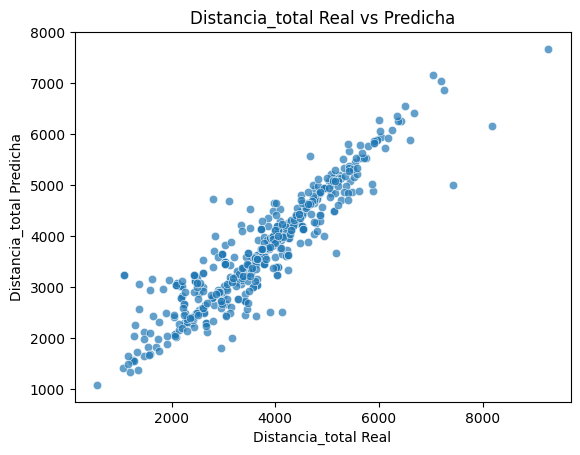

In [7]:
# =====================================================
# 6️⃣ EVALUACIÓN
# =====================================================
y_pred = model.predict(X_test_scaled)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rho, _ = spearmanr(y_test, y_pred)
cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2')

print("📊 Métricas de rendimiento Distancia_total:")
print(f"R²: {r2:.3f}")
print(f"MAE: {mae:.3f}")
print(f"Correlación Spearman (ρ): {rho:.3f}")
print(f"✅ R² (CV 5 folds): {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

# =====================================================
# 7️⃣ VISUALIZACIÓN DE COHERENCIA
# =====================================================
df_eval = pd.DataFrame({'Real': y_test, 'Predicho': y_pred})
sns.scatterplot(data=df_eval, x='Real', y='Predicho', alpha=0.7)
plt.title("Distancia_total Real vs Predicha")
plt.xlabel("Distancia_total Real")
plt.ylabel("Distancia_total Predicha")
plt.show()

In [8]:
# =====================================================
# 8️⃣ EXPORTAR MODELO Y SCALER
# =====================================================
output_dir = r"C:\Users\Nico\Desktop\DATA SCIENCE\PP- VOLUNTAREADO\chivas-ml\src\chivas_ml\ml\registry\Prueba_ML2.0\Modelo_Diario_Micro\Modelo_clas_Distancia_total"
os.makedirs(output_dir, exist_ok=True)

joblib.dump(model, os.path.join(output_dir, "model_Distancia_total_diario_etapa2.pkl"))
joblib.dump(scaler, os.path.join(output_dir, "scaler_Distancia_total_diario_etapa2.pkl"))

print(f"💾 Modelo y scaler guardados en: {output_dir}")


💾 Modelo y scaler guardados en: C:\Users\Nico\Desktop\DATA SCIENCE\PP- VOLUNTAREADO\chivas-ml\src\chivas_ml\ml\registry\Prueba_ML2.0\Modelo_Diario_Micro\Modelo_clas_Distancia_total
